In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from read_db.CH import Getch
import pandas as pd
from scipy import stats
from random import seed

sns.set(rc={'figure.figsize': (16, 10)}, style='whitegrid')

In [2]:
begin_date_str = '2022-03-08'
end_date_str = '2022-03-14'
groups_tuple = (2,3)
    
q = f"""SELECT  exp_group,
                user_id,
                sum(action = 'like') as likes,
                sum(action = 'view') as views,
                likes/views as ctr
FROM simulator_20220320.feed_actions 
WHERE toDate(time) between '{begin_date_str}' and '{end_date_str}'
    and exp_group in {groups_tuple}
GROUP BY exp_group, user_id
"""

In [3]:
df = Getch(q).df

In [4]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


In [5]:
df2 = df.query('exp_group == 2').drop('exp_group', axis = 1)
df3 = df.query('exp_group == 3').drop('exp_group', axis = 1)

In [6]:
len(df2), len(df3)

(8480, 8569)

In [7]:
def ttest_2_samples_from_dfs_n_times(df1, df2, n_test, sample_size):
    seed = len(df1) + len(df2) * n_test
    res = []
    for i in range(n_test):
        res.append(stats.ttest_ind(a=df1.sample(n=sample_size, replace=True).ctr, b=df2.sample(n=sample_size, replace=True).ctr, equal_var=False).pvalue)
    return pd.DataFrame(res, columns=['pvalue'])

In [8]:
test_res = ttest_2_samples_from_dfs_n_times(df2, df3, n_test=10000, sample_size=500)

1. Построить гистограмму распределения получившихся 10000 p-values.

<AxesSubplot:ylabel='Count'>

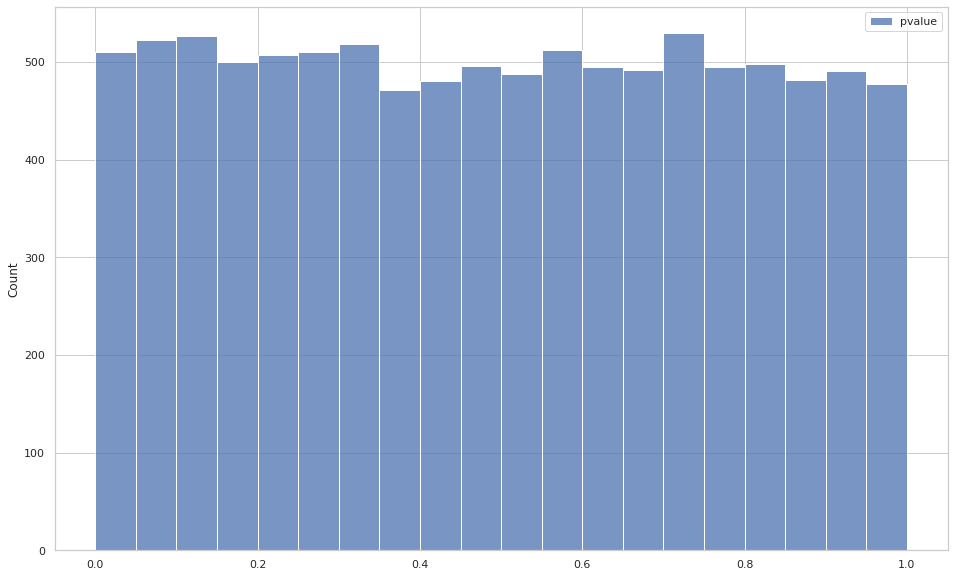

In [9]:
sns.histplot(test_res, bins=20, stat='count')

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

In [10]:
less_percentage = (test_res[test_res.pvalue <= 0.05].count() / test_res.count()).pvalue
less_percentage

0.051

In [11]:
print(f'Difference from 0.05 is {less_percentage - 0.05:.4f}, which is {((less_percentage - 0.05) / 0.05) * 100 :.2f}%')

Difference from 0.05 is 0.0010, which is 2.00%


3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

По результатам этого эксперимента мы утверждаем, что система сплитования работает корректно: процент ложных срабатываний очень близок к целевому показателю 0.05.